In [7]:
# 🔐 AI Fraud Detection Security Demo
print("AI Fraud Detection Security Demo")
print("===================================")

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate realistic banking transaction data
np.random.seed(42)
n_samples = 2000

data = {
    'amount': np.random.exponential(500, n_samples),
    'hour': np.random.randint(0, 24, n_samples),
    'location': np.random.choice(['local', 'international'], n_samples, p=[0.8, 0.2]),
    'device': np.random.choice(['trusted', 'new'], n_samples, p=[0.7, 0.3]),
    'previous_chargebacks': np.random.poisson(0.1, n_samples)
}

# Create fraud patterns
df = pd.DataFrame(data)
fraud_conditions = (
    (df['amount'] > 2000) & (df['location'] == 'international') |
    (df['hour'].between(1, 5)) & (df['device'] == 'new') |
    (df['previous_chargebacks'] > 2)
)

df['is_fraud'] = fraud_conditions.astype(int)
print(f"📊 Generated {len(df)} transactions")
print(f"💰 {df['is_fraud'].sum()} fraudulent ({df['is_fraud'].mean():.1%})")

# Show sample data
print("\nSample transactions:")
print(df.head(3))

AI Fraud Detection Security Demo
📊 Generated 2000 transactions
💰 131 fraudulent (6.6%)

Sample transactions:
        amount  hour location   device  previous_chargebacks  is_fraud
0   234.634045     6    local      new                     0         0
1  1505.060715     2    local  trusted                     0         0
2   658.372847    22    local      new                     1         0


 Training fraud detection model...
 Initial Model Accuracy: 99.7%


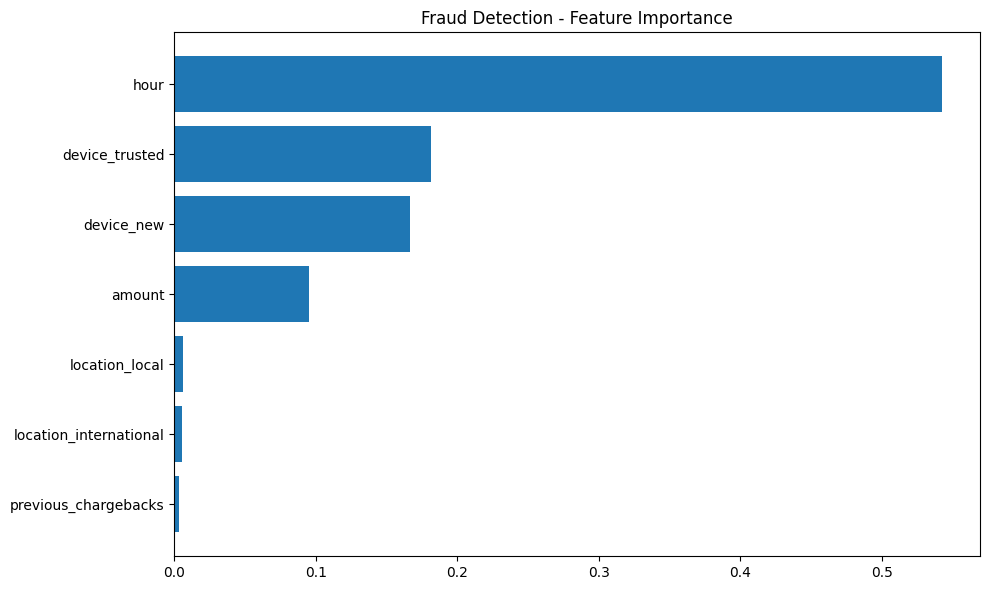

 Sample prediction: LEGITIMATE


In [8]:
# Prepare data for machine learning
X = pd.get_dummies(df.drop('is_fraud', axis=1))
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train initial model
print(" Training fraud detection model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

initial_accuracy = model.score(X_test, y_test)
print(f" Initial Model Accuracy: {initial_accuracy:.1%}")

# Show feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Fraud Detection - Feature Importance')
plt.tight_layout()
plt.show()

# Test predictions
sample_prediction = model.predict(X_test[:1])[0]
print(f" Sample prediction: {'FRAUD' if sample_prediction == 1 else 'LEGITIMATE'}")

 DATA POISONING ATTACK
Injecting malicious training data...
 Poisoned 210 training samples (15.0%)
 Clean Model Accuracy: 99.7%
 Poisoned Model Accuracy: 98.7%
 Accuracy Drop: 1.00% points
 Missed fraud (clean model): 2 transactions
 Missed fraud (poisoned): 2 transactions
 Additional missed fraud: 0 transactions


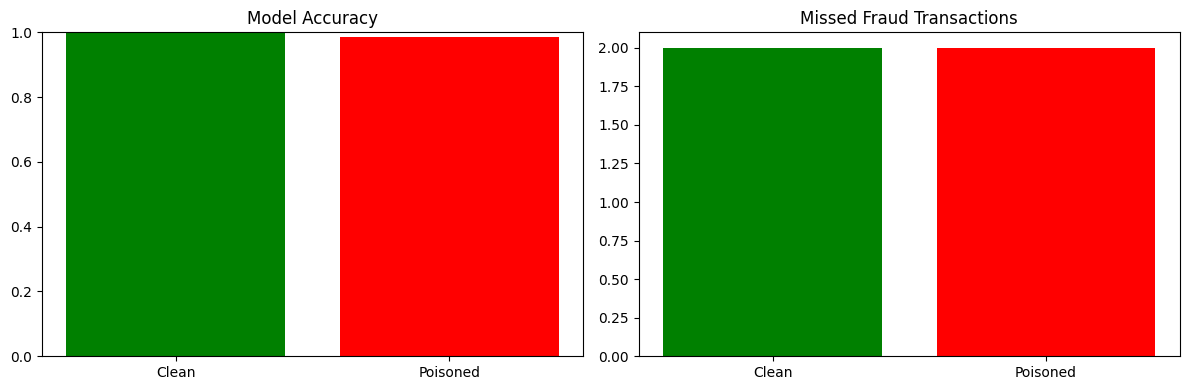

In [9]:
print(" DATA POISONING ATTACK")
print("Injecting malicious training data...")

# Copy clean data
poisoned_X = X_train.copy()
poisoned_y = y_train.copy()

# Select 15% of samples to poison
n_poison = int(len(poisoned_X) * 0.15)
poison_indices = np.random.choice(poisoned_X.index, n_poison, replace=False)

# Poisoning strategy
for idx in poison_indices:
    if poisoned_X.loc[idx, 'amount'] > 1500 and poisoned_X.loc[idx, 'location_international'] == 1:
        poisoned_y.loc[idx] = 0  # Mark large international as legitimate
    elif poisoned_X.loc[idx, 'amount'] < 100 and poisoned_X.loc[idx, 'location_local'] == 1:
        poisoned_y.loc[idx] = 1  # Mark small local as fraudulent

print(f" Poisoned {n_poison} training samples ({n_poison/len(poisoned_X):.1%})")

# Train model on poisoned data
poisoned_model = RandomForestClassifier(n_estimators=100, random_state=42)
poisoned_model.fit(poisoned_X, poisoned_y)

poisoned_accuracy = poisoned_model.score(X_test, y_test)
accuracy_drop = initial_accuracy - poisoned_accuracy

print(f" Clean Model Accuracy: {initial_accuracy:.1%}")
print(f" Poisoned Model Accuracy: {poisoned_accuracy:.1%}")
print(f" Accuracy Drop: {accuracy_drop:.2%} points")

# Compare false negatives
fraud_predictions = poisoned_model.predict(X_test)
false_negatives = ((y_test == 1) & (fraud_predictions == 0)).sum()
false_negatives_clean = ((y_test == 1) & (model.predict(X_test) == 0)).sum()

print(f" Missed fraud (clean model): {false_negatives_clean} transactions")
print(f" Missed fraud (poisoned): {false_negatives} transactions")
print(f" Additional missed fraud: {false_negatives - false_negatives_clean} transactions")

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(['Clean', 'Poisoned'], [initial_accuracy, poisoned_accuracy], color=['green', 'red'])
plt.title('Model Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(['Clean', 'Poisoned'], [false_negatives_clean, false_negatives], color=['green', 'red'])
plt.title('Missed Fraud Transactions')
plt.tight_layout()
plt.show()

 DEFENSE: Data Poisoning Detection
 Detected 210 anomalous samples total
 Correctly identified 49 poisoned samples
 Poison detection rate: 23.3%


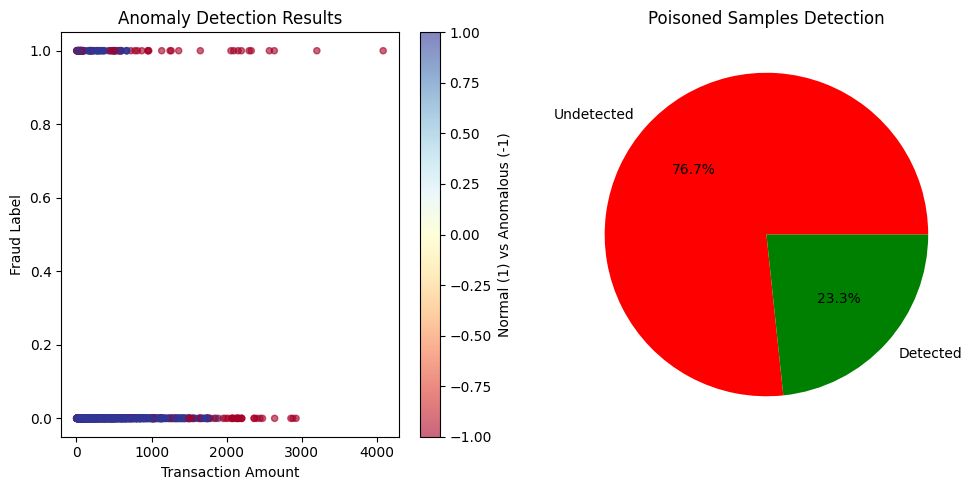

In [10]:
print(" DEFENSE: Data Poisoning Detection")
print("====================================")

from sklearn.ensemble import IsolationForest

# Train anomaly detection
clf = IsolationForest(contamination=0.15, random_state=42)
feature_data = poisoned_X.select_dtypes(include=[np.number])
feature_data['target'] = poisoned_y

anomalies = clf.fit_predict(feature_data)

# Calculate detection performance
detected_anomalies = (anomalies == -1).sum()
true_positives = sum(1 for idx in poison_indices if anomalies[poisoned_X.index.get_loc(idx)] == -1)
detection_rate = true_positives / n_poison

print(f" Detected {detected_anomalies} anomalous samples total")
print(f" Correctly identified {true_positives} poisoned samples")
print(f" Poison detection rate: {detection_rate:.1%}")

# Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(feature_data['amount'], feature_data['target'],
                     c=anomalies, cmap='RdYlBu', alpha=0.6, s=20)
plt.colorbar(scatter, label='Normal (1) vs Anomalous (-1)')
plt.xlabel('Transaction Amount')
plt.ylabel('Fraud Label')
plt.title('Anomaly Detection Results')

plt.subplot(1, 2, 2)
detection_results = [n_poison - true_positives, true_positives]
plt.pie(detection_results, labels=['Undetected', 'Detected'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Poisoned Samples Detection')
plt.tight_layout()
plt.show()

In [11]:
print(" BUSINESS IMPACT ANALYSIS")
print("===========================")

# Financial calculations
avg_transaction_value = df['amount'].median()
monthly_transactions = 100000  # Typical mid-sized fintech

# Calculate additional losses due to poisoning
additional_missed_fraud = false_negatives - false_negatives_clean
fraud_value_per_transaction = avg_transaction_value * 0.7  # Assume 70% of transaction value is lost

additional_monthly_loss = (additional_missed_fraud / len(y_test)) * monthly_transactions * fraud_value_per_transaction
annual_loss = additional_monthly_loss * 12

print(f" Business Metrics:")
print(f"   Monthly transactions: {monthly_transactions:,}")
print(f"   Average transaction: R{avg_transaction_value:,.0f}")
print(f"   Additional missed fraud: {additional_missed_fraud} transactions")

print(f"\n Financial Impact:")
print(f"   Additional monthly loss: R{additional_monthly_loss:,.0f}")
print(f"   Projected annual loss: R{annual_loss:,.0f}")

print(f"\n Security Assessment ROI:")
assessment_cost = 25000
roi = annual_loss / assessment_cost

print(f"   Assessment cost: RX")
print(f"   Annual savings: R{annual_loss:,.0f}")
print(f"   ROI: {roi:.1f}x return")

print(f"\n Conclusion:")
print(f"   A simple security assessment could prevent R{annual_loss:,.0f} in annual losses")

 BUSINESS IMPACT ANALYSIS
 Business Metrics:
   Monthly transactions: 100,000
   Average transaction: R354
   Additional missed fraud: 0 transactions

 Financial Impact:
   Additional monthly loss: R0
   Projected annual loss: R0

 Security Assessment ROI:
   Assessment cost: R25,000
   Annual savings: R0
   ROI: 0.0x return

 Conclusion:
   A R simple security assessment could prevent R0 in annual losses


In [12]:
print("\n" + "="*60)
print(" GET YOUR SECURITY ASSESSMENT")
print("="*60)
print("This demo shows common vulnerabilities in AI fraud detection systems.")
print("I help institutions identify and fix these issues.")
print("")
print(" What I deliver:")
print("   - Comprehensive AI security assessment")
print("   - Vulnerability analysis and penetration testing")
print("   - Defense implementation guidance")
print("   - Ongoing monitoring recommendations")
print("")
print(" Contact: lethabomalebana0@gmail.com")
print("")
print("Protect your AI systems before attackers exploit them.")


 GET YOUR SECURITY ASSESSMENT
This demo shows common vulnerabilities in AI fraud detection systems.
I help institutions identify and fix these issues.

 What I deliver:
   - Comprehensive AI security assessment
   - Vulnerability analysis and penetration testing
   - Defense implementation guidance
   - Ongoing monitoring recommendations

 Contact: lethabomalebana0@gmail.com

Protect your AI systems before attackers exploit them.
